Tutorial on computational modeling and statistical model fitting as a part the *Trends in Computational Neuroscience* graduate course of the University of Geneva (March-April 2020). **Lecturer:** [Luigi Acerbi](http://luigiacerbi.com/).

**Instructions:** 
- To run the tutorial, you will need a standard scientific Python 3.x installation with Jupyter notebook (such as [Anaconda](https://www.anaconda.com/distribution/)). 
- You will also need the `CMA-ES` optimization algorithm (see [here](https://github.com/CMA-ES/pycma)). You can install CMA-ES from the command line with `pip install cma`.
- For any question, please email the course instructor at luigi.acerbi@unige.ch.

**Initial setup and loading the data:**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.stats import norm
import cma
import seaborn as sns

During this tutorial, we are going to use data from the [International Brain Laboratory](https://www.internationalbrainlab.com/) publicly released behavioral mouse dataset, from exemplar mouse `KS014`. See [this preprint](https://www.biorxiv.org/content/10.1101/2020.01.17.909838v2) for more information about the task and datasets. These data can also be inspected via the IBL DataJoint public interface [here](https://data.internationalbrainlab.org/mouse/18a54f60-534b-4ed5-8bda-b434079b8ab8).

For convenience, the data of all behavioral sessions from examplar mouse `KS014` have been already downloaded in the `data` folder and slightly preprocessed into two `.csv` files, one for the training sessions (`KS014_train.csv`) and one with the *biased* sessions (`KS014_biased.csv`). 

We begin our tutorial by examining the training sessions. 

In [2]:
df = pd.read_csv('./data/KS014_train.csv')              # Load .csv file into a pandas DataFrame

df['signed_contrast'] = df['contrast']*df['position']   # We define a new column for "signed contrasts"
df.drop(columns='stim_probability_left', inplace=True)  # Stimulus probability has no meaning for training sessions

print('Total # of trials: ' + str(len(df['trial_num'])))
print('Sessions: ' + str(np.unique(df['session_num'])))
df.head()

Total # of trials: 10310
Sessions: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


,trial_num,session_num,contrast,position,response_choice,trial_correct,reaction_time,signed_contrast
0,1,1,100.0,-1.0,-1,1.0,1.052300,-100.0
1,2,1,50.0,1.0,1,1.0,0.276001,50.0
2,3,1,50.0,1.0,-1,0.0,2.094101,50.0
3,4,1,50.0,-1.0,1,0.0,3.407901,-50.0
4,5,1,50.0,1.0,1,1.0,1.601400,50.0


**Inspecting the data:**

The first thing to do with any dataset is to get familiar with it by running simple visualizations. Just plot stuff!
For example, as a starter we plot data from individual sessions using a *scatterplot* format (perhaps not the best). What can we see from here?

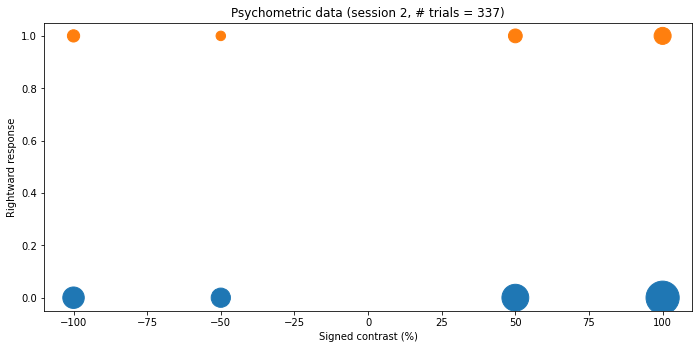

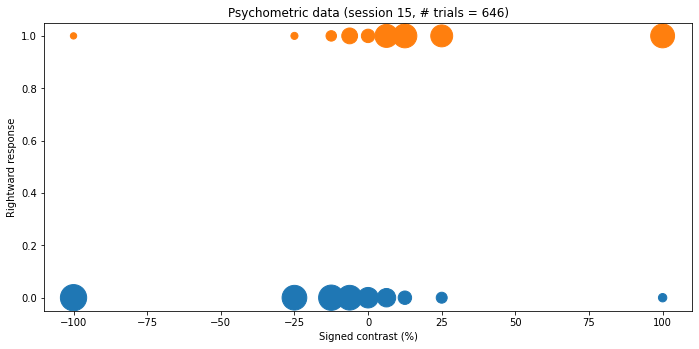

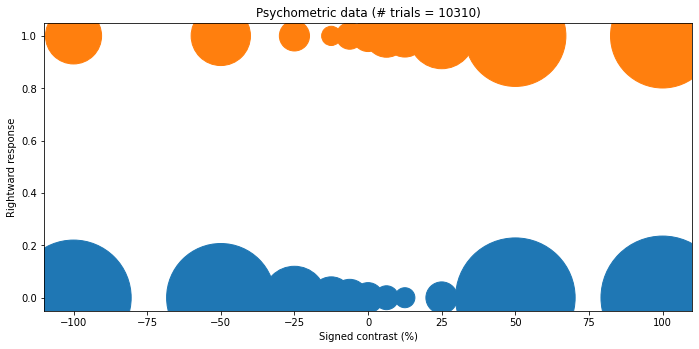

In [4]:
def scatterplot_psychometric_data(df,session_num=None,ax=None):
    """Plot psychometric data (optionally, of a chosen training session) as a scatter plot."""
    
    if session_num == None:
        trial_mask = np.ones(len(df['session_num']), dtype=bool) # Select all trials
    else:
        trial_mask = df['session_num'] == session_num # Indexes of trials of the chosen session
    Ntrials = np.sum(trial_mask) # Number of chosen trials
    
    # Count "left" and "right" responses for each signed contrast level
    left_resp = df[(df['response_choice'] == -1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']
    right_resp = df[(df['response_choice'] == 1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']    
    
    if ax == None:
        ax=fig.add_axes([0,0,1,1])
    ax.scatter(left_resp.index,np.zeros(len(left_resp.index)), s=left_resp*10);
    ax.scatter(right_resp.index,np.ones(len(right_resp.index)), s=right_resp*10);
    ax.set_xlabel('Signed contrast (%)')
    ax.set_ylabel('Rightward response')
    if session_num == None:
        ax.set_title('Psychometric data (# trials = ' + str(Ntrials) + ')')        
    else:
        ax.set_title('Psychometric data (session ' + str(session_num) + ', # trials = ' + str(Ntrials) + ')')        
    return ax

# Plot 2nd session
fig = plt.figure(figsize=(9,4))
scatterplot_psychometric_data(df,2)
plt.show()

# Plot 15th session (last training session)
fig = plt.figure(figsize=(9,4))
scatterplot_psychometric_data(df,15)
plt.show()

# Plot all sessions 
fig = plt.figure(figsize=(9,4))
scatterplot_psychometric_data(df)
plt.show()


We plot the same data again, this time with a different type of plot which may be more informative.

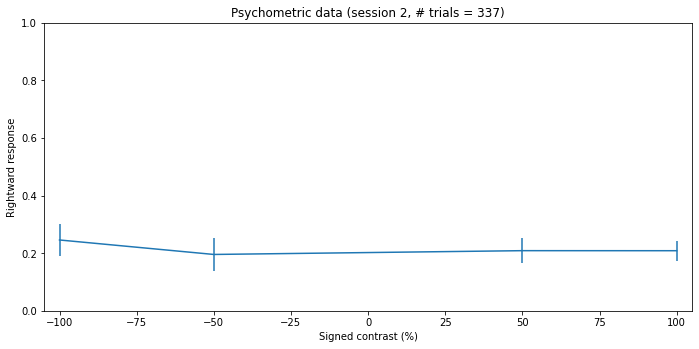

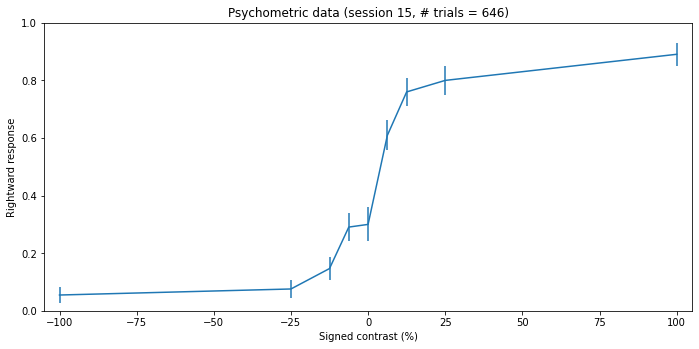

In [3]:
def plot_psychometric_data(df,session_num=None,ax=None):
    """Plot psychometric data (optionally, of a chosen training session) as a scatter plot."""
    
    if session_num == None:
        trial_mask = np.ones(len(df['session_num']), dtype=bool) # Select all trials
    else:
        trial_mask = df['session_num'] == session_num # Indexes of trials of the chosen session
    Ntrials = np.sum(trial_mask) # Number of chosen trials
        
    # Count "left" and "right" responses for each signed contrast level
    left_resp = df[(df['response_choice'] == -1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']
    right_resp = df[(df['response_choice'] == 1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']    
    
    frac_resp = right_resp / (left_resp + right_resp)
    err_bar = np.sqrt(frac_resp*(1-frac_resp)/(left_resp + right_resp)) # Why this formula for error bars?
    
    if ax == None:
        ax=fig.add_axes([0,0,1,1])
    ax.errorbar(x=left_resp.index,y=frac_resp,yerr=err_bar,label='data');
    ax.set_xlabel('Signed contrast (%)')
    ax.set_ylabel('Rightward response')
    if session_num == None:
        ax.set_title('Psychometric data (# trials = ' + str(Ntrials) + ')')        
    else:
        ax.set_title('Psychometric data (session ' + str(session_num) + ', # trials = ' + str(Ntrials) + ')')        
    plt.xlim((-105,105))
    plt.ylim((0,1))
    return ax

fig = plt.figure(figsize=(9,4))
plot_psychometric_data(df,2)
plt.show()

fig = plt.figure(figsize=(9,4))
plot_psychometric_data(df,15)
plt.show()

**The psychometric function model:**

We define now the `basic` psychometric function (descriptive) model and a plotting function.

In [4]:
def psychofun(theta,stim):
    """Psychometric function based on normal CDF and lapses"""
    mu = theta[0]          # bias
    sigma = theta[1]       # slope/noise
    lapse = theta[2]       # lapse rate
    if len(theta) == 4:    # lapse bias
        lapse_bias = theta[3];
    else:
        lapse_bias = 0.5   # if theta has only three elements, assume symmetric lapses
    
    p_right = norm.cdf(stim,loc=mu,scale=sigma)    # Probability of responding "rightwards", without lapses
    p_right = lapse*lapse_bias + (1-lapse)*p_right # Adding lapses

    return p_right

def psychofun_plot(theta,ax):
    """Plot psychometric function"""    
    stim = np.linspace(-100,100,201)   # Create stimulus grid for plotting    
    p_right = psychofun(theta,stim)    # Compute psychometric function values
    ax.plot(stim,p_right,label='model')
    ax.legend()
    return

We now define the log likelihood function of the psychometric function model for a given dataset and model parameter vector, $\log p(\text{data}|\mathbf{\theta})$.

In [15]:
def psychofun_loglike(theta,df):
    """Log-likelihood for psychometric function model"""
    s_vec = df['signed_contrast'] # Stimulus values
    r_vec =  df['response_choice']  # Responses
    
    p_right = psychofun(theta,s_vec)
    
    # Compute summed log likelihood for all rightwards and leftwards responses
    loglike = np.sum(np.log(p_right[r_vec == 1])) + np.sum(np.log(1 - p_right[r_vec == -1]))

    return loglike

**Maximum-likelihood estimation:**

In this section, we are going to estimate model parameters (aka fit our models) by maximizing the log-likelihood. By convention in optimization, we are going to *minimize* the negative log-likelihood.

Before running the optimization, we define the *hard* lower and upper bounds for the parameters. If the optimization algorithm supports constrained (bound) optimization, it will never go outside the hard bounds. We also define informally the *plausible* bounds as the range of parameters that we would expect to see. We are going to use the plausible range to initialize the problem later.

In [16]:
# Define hard parameter bounds
lb = np.array([-100,1,0,0])
ub = np.array([100,100,1,1])
bounds = [lb,ub]

# Define plausible range
plb = np.array([-25,5,0.05,0.2])
pub = np.array([25,25,0.40,0.8])


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=387421, Wed Apr  8 14:43:04 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 5.013953681460774e+02 1.0e+00 4.78e-01  5e-01  5e-01 0:00.0
    2     16 3.454213129129129e+02 1.4e+00 4.84e-01  5e-01  5e-01 0:00.0
    3     24 3.381970838002925e+02 1.6e+00 5.26e-01  5e-01  6e-01 0:00.0
   86    688 3.099979856258913e+02 7.3e+02 2.28e-03  5e-06  4e-03 0:00.5
termination on tolfun=1e-05 (Wed Apr  8 14:43:04 2020)
final/bestever f-value = 3.099980e+02 3.099980e+02
incumbent solution: [-12.655280953804214, 12.10840688089221, 0.9999999999999623, 0.707603633232391]
std deviation: [0.0024221004763497313, 0.0035030487996811754, 2.0194900098098835e-05, 4.547266928428334e-06]

Session
1
Returned parameter vector: [-12.65528095  12.10840688   1.           0.70760363]
Negative log-likelihood at solution: 309.9979856221041


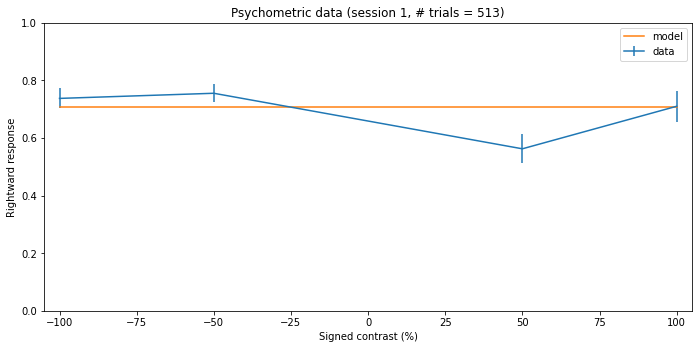

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=398482, Wed Apr  8 14:43:05 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.683838611665572e+02 1.0e+00 4.11e-01  4e-01  4e-01 0:00.0
    2     16 2.316590551038729e+02 1.3e+00 3.78e-01  3e-01  4e-01 0:00.0
    3     24 1.825041036876276e+02 1.4e+00 4.30e-01  4e-01  5e-01 0:00.0
   80    640 1.748195831021631e+02 8.8e+02 3.72e-03  5e-06  5e-03 0:00.4
termination on tolfun=1e-05 (Wed Apr  8 14:43:05 2020)
final/bestever f-value = 1.748196e+02 1.748196e+02
incumbent solution: [-1.8264818517589236, 14.201796523685456, 0.9999999999895098, 0.21364589545120907]
std deviation: [0.0038045890583719064, 0.005475907431690647, 4.122287980875671e-05, 5.245739261827286e-06]

Session
2
Returned parameter vector: [-1.82824448 14.18643694  1.          0.21364905]
Negative log-likelihood at solution: 174.8195830740604


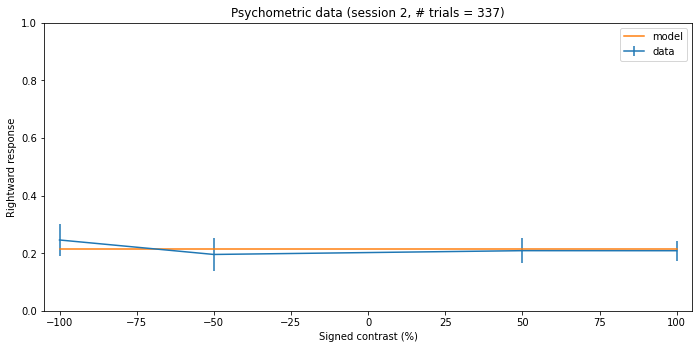

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=461746, Wed Apr  8 14:43:05 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.985488165184107e+02 1.0e+00 5.13e-01  5e-01  5e-01 0:00.0
    2     16 2.823516599563814e+02 1.2e+00 5.83e-01  5e-01  7e-01 0:00.0
    3     24 3.478732169427975e+02 1.5e+00 6.76e-01  6e-01  8e-01 0:00.0
   95    760 2.730440923870241e+02 8.0e+03 4.10e-03  3e-06  2e-02 0:00.6
termination on tolfun=1e-05 (Wed Apr  8 14:43:06 2020)
final/bestever f-value = 2.730441e+02 2.730441e+02
incumbent solution: [-7.94094622410367, 16.371300000292795, 0.9999999999880441, 0.24439797525116658]
std deviation: [0.022128063590540897, 0.008413558206720115, 1.7091426858693557e-05, 2.649159456983833e-06]

Session
3
Returned parameter vector: [-7.91412545 16.36426449  1.          0.24439863]
Negative log-likelihood at solution: 273.0440923864549


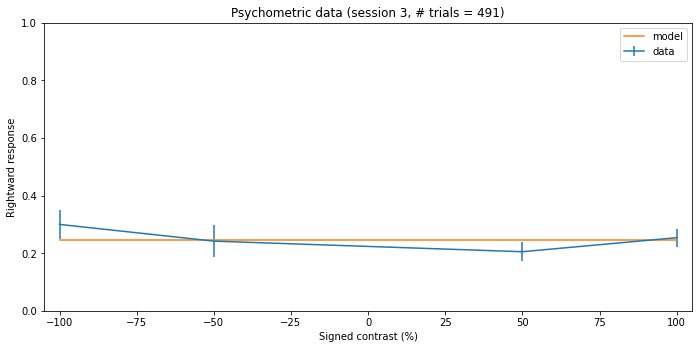

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=468985, Wed Apr  8 14:43:07 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.784954499538908e+02 1.0e+00 5.21e-01  5e-01  5e-01 0:00.0
    2     16 5.151745816711316e+02 1.3e+00 5.01e-01  4e-01  5e-01 0:00.0
    3     24 4.888937382229522e+02 1.4e+00 5.18e-01  4e-01  6e-01 0:00.0
  100    800 4.716922842000159e+02 5.9e+03 6.89e-02  8e-05  3e-01 0:00.7
NOTE (module=cma, iteration=108):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 3.2e+08 to 3.7e+01
  122    976 4.716922806151377e+02 7.2e+00 3.26e-02  7e-06  3e-01 0:00.8
termination on tolfun=1e-05 (Wed Apr  8 14:43:08 2020)
final/bestever f-value = 4.716923e+02 4.716923e+02
incumbent solution: [-10.430737902866824, 6.682725163817682, 0.9574085146710927, 0.308085143340531]
std deviation: [0.1884376759926706, 0.2599410947820516, 1.531639544570716e-05, 6.66594687438251e-06]

Session
4
Return

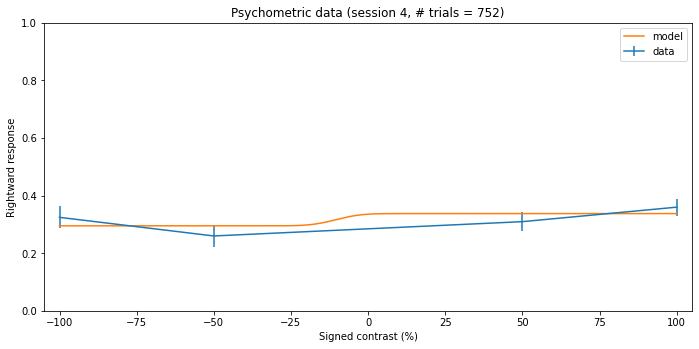

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=512705, Wed Apr  8 14:43:08 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 6.638981536914447e+02 1.0e+00 4.50e-01  4e-01  5e-01 0:00.0
    2     16 4.303164599357958e+02 1.2e+00 4.75e-01  4e-01  5e-01 0:00.0
    3     24 4.134215028642906e+02 1.5e+00 6.58e-01  6e-01  7e-01 0:00.0
  100    800 3.998993362821989e+02 2.5e+03 3.27e-03  2e-06  6e-03 0:00.6
  105    840 3.998993362678056e+02 3.4e+03 2.62e-03  2e-06  5e-03 0:00.6
termination on tolfun=1e-05 (Wed Apr  8 14:43:09 2020)
final/bestever f-value = 3.998993e+02 3.998993e+02
incumbent solution: [17.935858138400494, 17.938079260301443, 0.9999999999970905, 0.23401405456275748]
std deviation: [0.0028387784580676373, 0.004818149775148214, 9.928538203562174e-06, 1.5216621261004333e-06]

Session
5
Returned parameter vector: [17.93585814 17.93807926  1.          0.23401405]
Negative log-likelihood at solution: 399.89933626735944


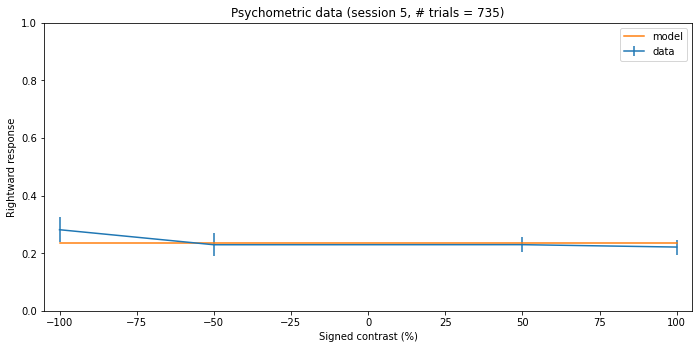

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=466914, Wed Apr  8 14:43:09 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.891682832074975e+02 1.0e+00 4.97e-01  4e-01  6e-01 0:00.0
    2     16 3.224258132791136e+02 1.3e+00 5.09e-01  4e-01  7e-01 0:00.0
    3     24 3.926122334366706e+02 1.6e+00 6.08e-01  5e-01  8e-01 0:00.0
  100    800 3.013280409404293e+02 2.8e+03 2.28e-02  6e-05  8e-02 0:00.6
  121    968 3.013280402804527e+02 5.4e+03 6.39e-03  6e-06  1e-02 0:00.8
termination on tolfun=1e-05 (Wed Apr  8 14:43:10 2020)
final/bestever f-value = 3.013280e+02 3.013280e+02
incumbent solution: [-28.071998371538825, 15.136620015234634, 0.8896274535427335, 0.02391845907489948]
std deviation: [0.011946778216152103, 0.006871968998735663, 5.784668137929092e-06, 7.021739798304753e-06]

Session
6
Returned parameter vector: [-2.80642460e+01  1.51425537e+01  8.89623621e-01  2.39150520e-02]
Negative log-likelihood at solution: 301.3280402473497

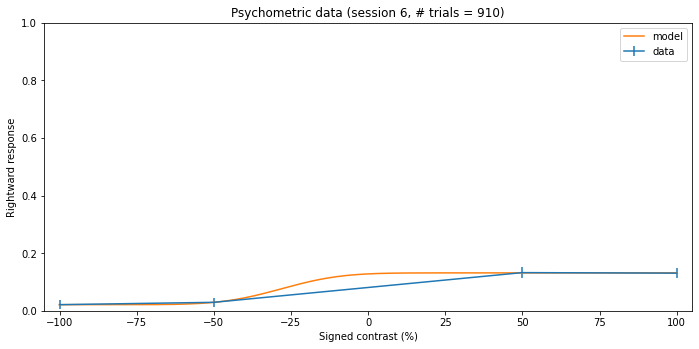

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=461779, Wed Apr  8 14:43:11 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 6.329474397388436e+02 1.0e+00 4.61e-01  4e-01  5e-01 0:00.0
    2     16 5.281429082097458e+02 1.3e+00 4.11e-01  3e-01  4e-01 0:00.0
    3     24 4.953074666404221e+02 1.5e+00 3.65e-01  3e-01  4e-01 0:00.0
  100    800 4.893141256196966e+02 7.3e+02 3.07e-02  7e-05  3e-02 0:00.7
NOTE (module=cma, iteration=140):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 4.8e+08 to 3.7e+03
  150   1200 4.893139976361896e+02 1.0e+02 2.75e-02  6e-06  9e-02 0:01.0
termination on tolfun=1e-05 (Wed Apr  8 14:43:12 2020)
final/bestever f-value = 4.893140e+02 4.893140e+02
incumbent solution: [-38.78127150359457, 16.086686144364947, 0.7125835526558792, 0.08198922945623488]
std deviation: [0.05986892004942532, 0.08658868332263218, 9.237847584389948e-06, 5.595612551593956e-06]

Session
7
R

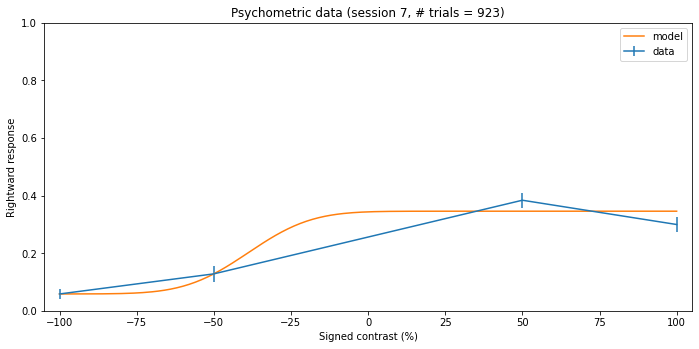

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=480692, Wed Apr  8 14:43:12 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.690730964920901e+02 1.0e+00 5.01e-01  5e-01  5e-01 0:00.0
    2     16 5.111842149205048e+02 1.4e+00 5.11e-01  5e-01  5e-01 0:00.0
    3     24 4.708178295656225e+02 1.5e+00 5.51e-01  5e-01  6e-01 0:00.0
  100    800 4.567987291243674e+02 5.9e+02 1.02e+00  5e-03  2e+00 0:00.5
  161   1288 4.567590673872232e+02 1.8e+04 7.18e-02  2e-05  2e-01 0:00.8
termination on tolfun=1e-05 (Wed Apr  8 14:43:13 2020)
final/bestever f-value = 4.567591e+02 4.567591e+02
incumbent solution: [-33.128897598044624, 15.146124701976204, 0.5657975759160058, 0.11114529387446756]
std deviation: [0.17945677120203793, 0.16110895921651092, 1.7223466210119593e-05, 2.0642323970753023e-05]

Session
8
Returned parameter vector: [-33.1288976   15.1461247    0.56579758   0.11114529]
Negative log-likelihood at solution: 456.7590672241254


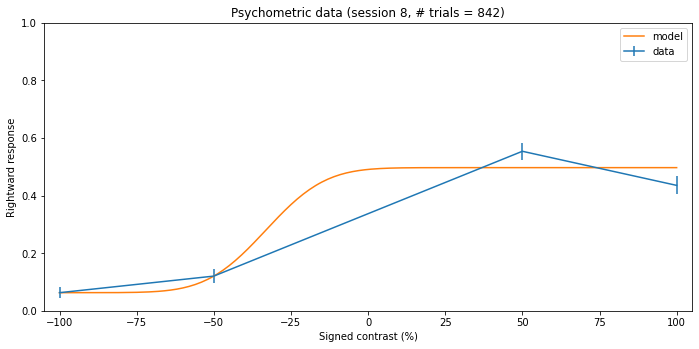

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=437030, Wed Apr  8 14:43:13 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.463694313307594e+02 1.0e+00 5.10e-01  5e-01  5e-01 0:00.0
    2     16 4.222876655243508e+02 1.5e+00 4.87e-01  4e-01  5e-01 0:00.0
    3     24 4.288585492802250e+02 1.7e+00 5.28e-01  5e-01  6e-01 0:00.0
NOTE (module=cma, iteration=97):  
condition in coordinate system exceeded 1.4e+08, rescaled to 1.0e+00, 
condition changed from 1.4e+08 to 7.1e+00
  100    800 3.387351518478093e+02 2.3e+00 2.18e-02  7e-06  1e-01 0:00.6
  114    912 3.387351518274047e+02 5.7e+00 5.34e-03  7e-07  2e-02 0:00.6
termination on tolfun=1e-05 (Wed Apr  8 14:43:14 2020)
final/bestever f-value = 3.387352e+02 3.387352e+02
incumbent solution: [-6.839355871012274, 2.7636815996088395, 0.5841281498079652, 0.0243698750443968]
std deviation: [0.02407909740427045, 0.013455481050619389, 8.397968436944858e-07, 6.678210186462614e-07]

Session
9
Re

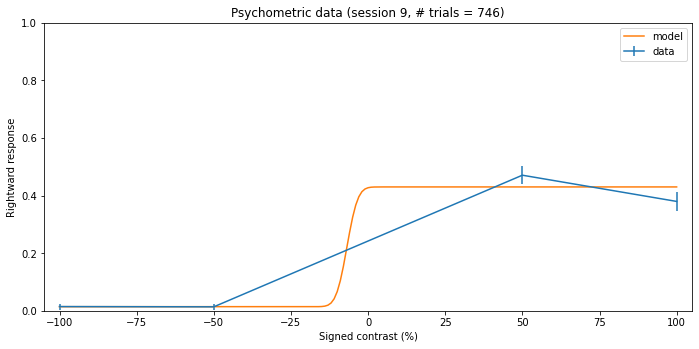

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=504415, Wed Apr  8 14:43:14 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.018977251066968e+02 1.0e+00 4.95e-01  5e-01  5e-01 0:00.0
    2     16 2.010794438193136e+02 1.3e+00 4.64e-01  4e-01  5e-01 0:00.0
    3     24 1.948633858937045e+02 1.5e+00 4.14e-01  3e-01  4e-01 0:00.0
  100    800 1.927228628534862e+02 3.7e+03 1.54e-02  1e-05  4e-02 0:00.5
  106    848 1.927228628444400e+02 6.1e+03 8.51e-03  4e-06  2e-02 0:00.6
termination on tolfun=1e-05 (Wed Apr  8 14:43:15 2020)
final/bestever f-value = 1.927229e+02 1.927229e+02
incumbent solution: [8.13341245325294, 1.6093687728009127, 0.40142580416576834, 0.8192991093469457]
std deviation: [0.02298872842807852, 0.019146749070758487, 3.6536963811009546e-06, 6.3111119875596296e-06]

Session
10
Returned parameter vector: [8.17797334 1.57494081 0.40142757 0.81929858]
Negative log-likelihood at solution: 192.72286283853094


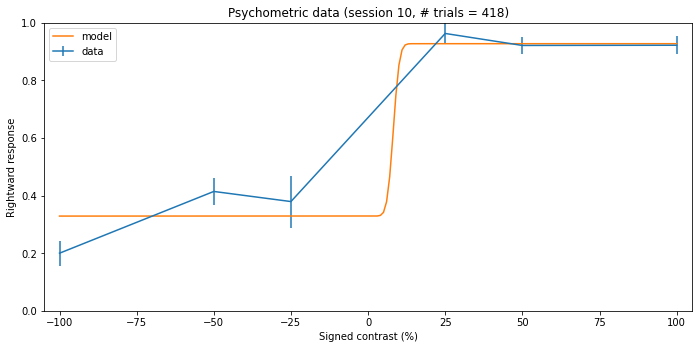

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=491405, Wed Apr  8 14:43:15 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.695155740044406e+02 1.0e+00 5.09e-01  5e-01  5e-01 0:00.0
    2     16 4.684729211105972e+02 1.3e+00 5.54e-01  5e-01  6e-01 0:00.0
    3     24 4.893952205166095e+02 1.6e+00 6.07e-01  5e-01  7e-01 0:00.0
  100    800 4.599776517973529e+02 3.2e+02 1.27e-02  4e-05  8e-03 0:00.6
  118    944 4.599776504574461e+02 3.6e+02 2.04e-03  3e-06  7e-04 0:00.8
termination on tolfun=1e-05 (Wed Apr  8 14:43:16 2020)
final/bestever f-value = 4.599777e+02 4.599777e+02
incumbent solution: [-4.819078043697787, 19.53187895760028, 0.45997113149449825, 0.23621666258921556]
std deviation: [0.0006564582945242438, 0.0005194643375402638, 2.5335725397780076e-06, 4.8679333185657345e-06]

Session
11
Returned parameter vector: [-4.81880797 19.53206634  0.4599706   0.23621712]
Negative log-likelihood at solution: 459.97765045744615


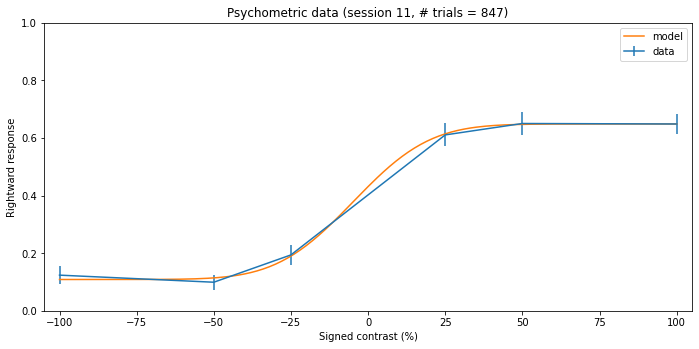

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=441846, Wed Apr  8 14:43:17 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.669543075417778e+02 1.0e+00 5.16e-01  5e-01  5e-01 0:00.0
    2     16 3.490848731119319e+02 1.3e+00 5.77e-01  5e-01  7e-01 0:00.0
    3     24 3.606951841364402e+02 1.5e+00 5.92e-01  5e-01  7e-01 0:00.0
  100    800 3.358246464467967e+02 2.2e+02 6.30e-02  3e-04  5e-02 0:00.8
  137   1096 3.358244379698314e+02 1.9e+02 1.52e-03  2e-06  2e-04 0:01.0
termination on tolfun=1e-05 (Wed Apr  8 14:43:18 2020)
final/bestever f-value = 3.358244e+02 3.358244e+02
incumbent solution: [-10.067386420937417, 20.510197857836193, 0.25902690059194705, 0.5454217401470483]
std deviation: [0.00019517129211282674, 0.00023272861850417124, 1.6091524718629617e-06, 3.851908023667551e-06]

Session
12
Returned parameter vector: [-10.06738642  20.51019786   0.2590269    0.54542174]
Negative log-likelihood at solution: 335.8244379677242


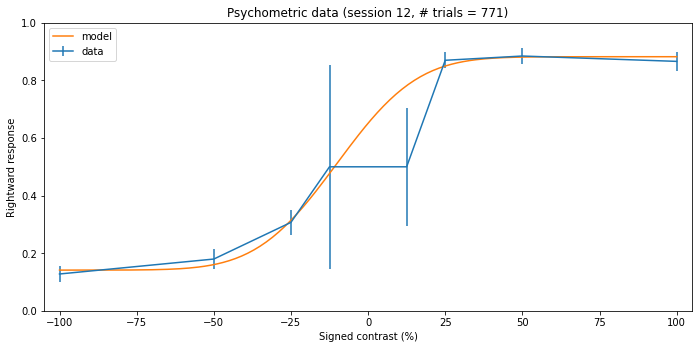

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=431988, Wed Apr  8 14:43:18 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.194911148498225e+02 1.0e+00 4.50e-01  4e-01  5e-01 0:00.0
    2     16 2.705110770716514e+02 1.2e+00 4.33e-01  4e-01  5e-01 0:00.0
    3     24 2.748354891177705e+02 1.5e+00 3.75e-01  3e-01  4e-01 0:00.0
  100    800 1.991691791807477e+02 8.8e+01 5.28e-01  6e-03  3e-01 0:00.6
  160   1280 1.991013178758063e+02 1.5e+02 2.30e-03  3e-06  2e-04 0:00.9
termination on tolfun=1e-05 (Wed Apr  8 14:43:19 2020)
final/bestever f-value = 1.991013e+02 1.991013e+02
incumbent solution: [-5.125046517495015, 9.668390575563409, 0.07700922761141987, 0.2707021686241229]
std deviation: [0.00014494174217215736, 0.00023231358116782886, 2.649195941901112e-06, 1.4042177704808702e-05]

Session
13
Returned parameter vector: [-5.12516671  9.66812361  0.07700949  0.27070178]
Negative log-likelihood at solution: 199.1013178675692


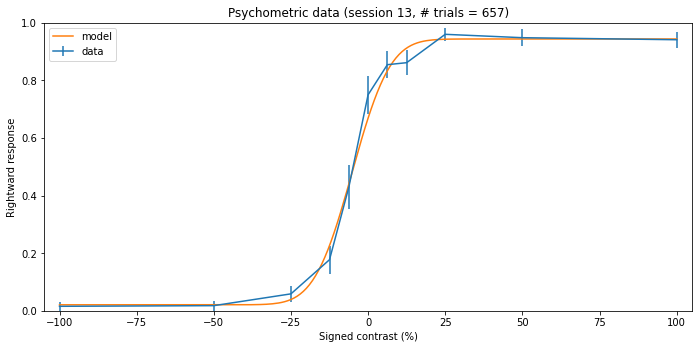

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=451272, Wed Apr  8 14:43:20 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.482450669314553e+02 1.0e+00 5.04e-01  5e-01  5e-01 0:00.0
    2     16 3.527722397893093e+02 1.3e+00 5.56e-01  5e-01  6e-01 0:00.0
    3     24 3.551865590437787e+02 1.5e+00 5.73e-01  4e-01  7e-01 0:00.0
  100    800 2.986582882723145e+02 8.6e+01 3.38e-02  2e-04  1e-02 0:00.5
  132   1056 2.986582720759099e+02 7.4e+01 1.13e-03  2e-06  1e-04 0:00.7
termination on tolfun=1e-05 (Wed Apr  8 14:43:20 2020)
final/bestever f-value = 2.986583e+02 2.986583e+02
incumbent solution: [-1.975877072890946, 9.242490091411053, 0.13994454112827379, 0.6275536283218641]
std deviation: [6.0633775878608195e-05, 9.670662420190223e-05, 1.891169098705555e-06, 6.937096547170091e-06]

Session
14
Returned parameter vector: [-1.97591837  9.24253056  0.13994317  0.62755014]
Negative log-likelihood at solution: 298.65827206822615


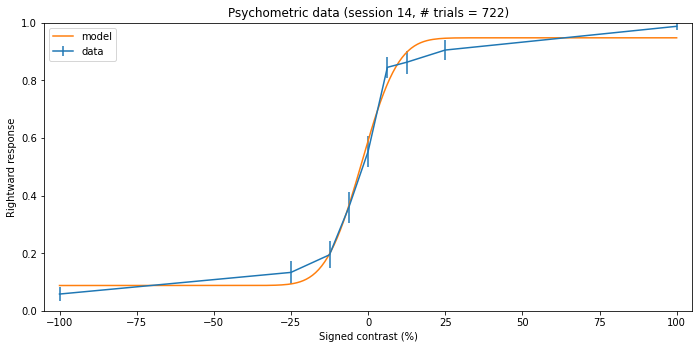

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=438486, Wed Apr  8 14:43:21 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.186743855076204e+02 1.0e+00 4.69e-01  4e-01  5e-01 0:00.0
    2     16 3.216724012452701e+02 1.3e+00 4.40e-01  4e-01  5e-01 0:00.0
    3     24 3.336431709249621e+02 1.6e+00 3.55e-01  3e-01  4e-01 0:00.0
  100    800 3.076344960335566e+02 5.7e+01 5.45e-03  3e-05  1e-03 0:00.5
  111    888 3.076344953517911e+02 5.9e+01 2.64e-03  1e-05  5e-04 0:00.6
termination on tolfun=1e-05 (Wed Apr  8 14:43:21 2020)
final/bestever f-value = 3.076345e+02 3.076345e+02
incumbent solution: [1.8621551236144789, 11.513157898225154, 0.1946476223101994, 0.3150518223240832]
std deviation: [0.0002819616602969193, 0.0004501374699953254, 1.179851813682295e-05, 2.4450354407709802e-05]

Session
15
Returned parameter vector: [ 1.86215512 11.5131579   0.19464762  0.31505182]
Negative log-likelihood at solution: 307.63449533585737


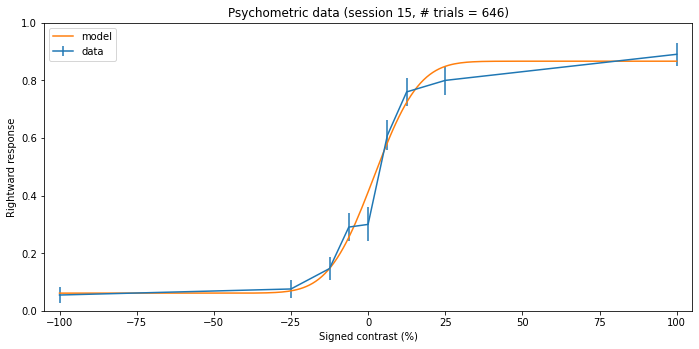

In [36]:
theta1 = []
theta2 = []
theta3 = []
theta4 = [] 
negLL =  []

for session_num in range(1,16): # loop over session data

    df_session = df[df['session_num'] == session_num]
    # Define objective function: negative log-likelihood
    opt_fun = lambda theta_: -psychofun_loglike(theta_,df_session)
    
    # Generate random starting point for the optimization inside the plausible box
    theta0 = np.random.uniform(low=plb,high=pub) 

    # Initialize CMA-ES algorithm
    opts = cma.CMAOptions()
    opts.set("bounds",bounds)
    opts.set("tolfun",1e-5)

    # Run optimization
    res = cma.fmin(opt_fun, theta0, 0.5, opts)

    print('')
    print('Session') 
    print(session_num)
    print('Returned parameter vector: ' + str(res[0]))
    print('Negative log-likelihood at solution: ' + str(res[1]))
    vec =res[0]

    theta1.append(vec[0])
    theta2.append(vec[1])
    theta3.append(vec[2])
    theta4.append(vec[3])
    
    negLL.append(res[1])

    fig = plt.figure(figsize=(9,4))
    ax = plot_psychometric_data(df_session,session_num)
    psychofun_plot(res[0],ax)
    plt.show()

In [110]:
#1a)

session = np.linspace(1,15,15, dtype=int)


In [222]:
def plot_sess_param(X, Y1, label1, Y2=None,  label2=None, labelALL=None, caption=None):  
    sns.set_style("darkgrid")
    plt.figure(figsize=(9, 4))  
    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  
    #plt.ylim(63, 85)  
    plt.xticks(range(1, 16, 1), fontsize=10)  
    #plt.yticks(range(65, 86, 5), fontsize=14) 
    plt.xlabel("Session", fontsize=16)
    
    if caption!=None:
        plt.figtext(0.5, 0.5, caption, wrap=False, horizontalalignment='center', fontsize=12)
        
    if Y2==None:
        plt.ylabel(label1, fontsize=16) 
        plt.plot(sess, Y1, color="blue", lw=2)  
    else:
        plt.plot(sess, Y1, color="blue", lw=2, label=label1)  
        plt.plot(sess, Y2, color="orange", lw=2, label=label2)  
        plt.ylabel(labelALL, fontsize=16) 
        plt.legend()
    #plt.title("Theta as a function of session", fontsize=22)  
     
    #plt.savefig("XXX.png", bbox_inches="tight");  

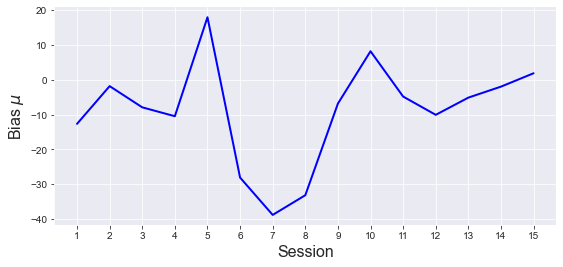

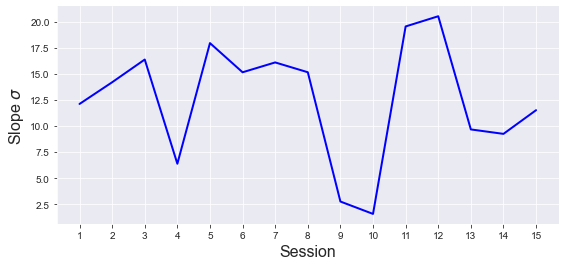

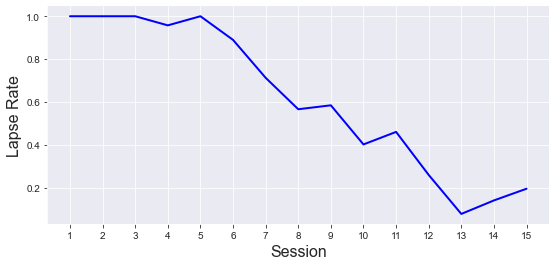

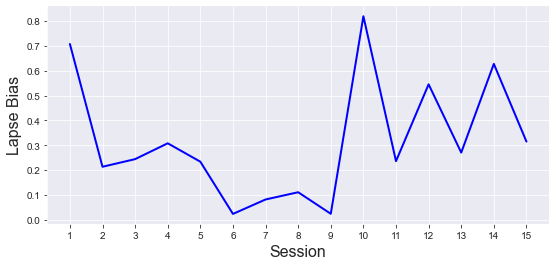

In [207]:
plot_sess_param(session, theta1, 'Bias $\mu$')
plot_sess_param(session, theta2, 'Slope $\sigma$')
plot_sess_param(session, theta3, 'Lapse Rate')
plot_sess_param(session, theta4, 'Lapse Bias')

**Model comparison:**

We consider now a slightly more advanced model which includes time dependency by having the response in the current trial being influenced by the response in the previous trial. We adopt a simple model, `repeatlast`, in which the observer has a fixed chance of repeating the previous choice.

In [58]:
def psychofun_repeatlast_loglike(theta,df):
    """Log-likelihood for last-choice dependent psychometric function model"""
    s_vec = np.array(df['signed_contrast']) # Stimulus values
    r_vec = np.array(df['response_choice'])  # Responses
    
    p_last = theta[0] # Probability of responding as last choice
    theta_psy = theta[1:] # Standard psychometric function parameters
        
    p_right = psychofun(theta_psy,s_vec)
    
    # Starting from the 2nd trial, probability of responding equal to the last trial
    p_right[1:] = p_last*(r_vec[0:-1] == 1) + (1-p_last)*p_right[1:] 
    
    # Compute summed log likelihood for all rightwards and leftwards responses
    loglike = np.sum(np.log(p_right[r_vec == 1])) + np.sum(np.log(1 - p_right[r_vec == -1]))

    return loglike

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=404831, Wed Apr  8 16:50:58 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.777074336927538e+02 1.0e+00 4.46e-01  4e-01  5e-01 0:00.0
    2     16 4.934023846548197e+02 1.2e+00 4.00e-01  4e-01  4e-01 0:00.0
    3     24 3.692157369140422e+02 1.3e+00 3.54e-01  3e-01  4e-01 0:00.0
   98    784 3.090024728583969e+02 2.4e+02 4.11e-04  3e-06  8e-04 0:00.4
termination on tolfun=1e-05 (Wed Apr  8 16:50:58 2020)
final/bestever f-value = 3.090025e+02 3.090025e+02
incumbent solution: [0.06302400149033072, 1.1671002642278303, 9.196013818242239, 0.9999999999400703, 0.7074183518875583]
std deviation: [7.426535652834455e-06, 0.0005888378142878425, 0.0008239364345249016, 9.430076464456521e-06, 3.395280343031161e-06]

Session
1
Returned parameter vector: [0.06303033 1.16805656 9.19583972 1.         0.70741994]
Negative log-likelihood at solution: 309.00247284912194


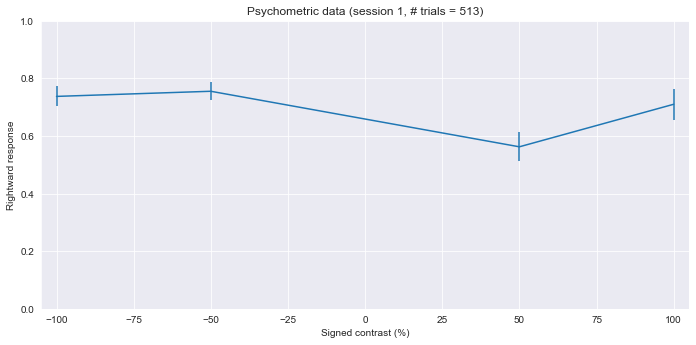

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=421433, Wed Apr  8 16:50:59 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.862292217885032e+02 1.0e+00 5.15e-01  5e-01  6e-01 0:00.0
    2     16 2.980794471993454e+02 1.4e+00 5.08e-01  4e-01  5e-01 0:00.0
    3     24 2.151710393336539e+02 1.6e+00 5.17e-01  5e-01  5e-01 0:00.0
  100    800 1.748025533181685e+02 3.9e+02 1.13e-02  8e-05  2e-02 0:00.4
  128   1024 1.748025431967218e+02 1.9e+03 9.51e-04  2e-06  3e-03 0:00.5
termination on tolfun=1e-05 (Wed Apr  8 16:51:00 2020)
final/bestever f-value = 1.748025e+02 1.748025e+02
incumbent solution: [0.0100807224621331, 5.226416802743979, 22.796888078822413, 0.9999999999999961, 0.2136374362931133]
std deviation: [9.328250030829033e-06, 0.0028936761472563603, 0.001994763152759576, 1.3324061148687642e-05, 1.8593737781874868e-06]

Session
2
Returned parameter vector: [1.00807225e-02 5.22641680e+00 2.27968881e+01 1.00000000e+00
 2.13637436e-01]

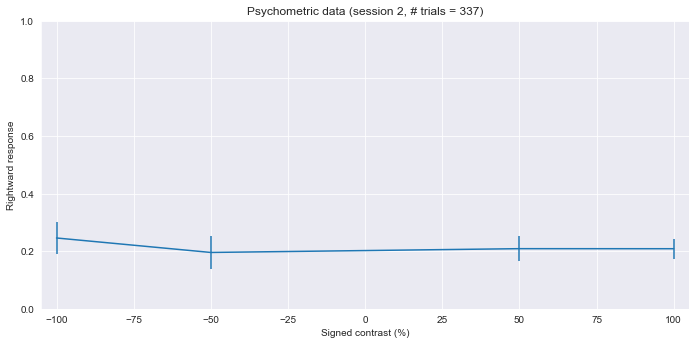

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=423150, Wed Apr  8 16:51:00 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.738073697897348e+02 1.0e+00 5.40e-01  5e-01  6e-01 0:00.0
    2     16 3.071464135030602e+02 1.3e+00 5.65e-01  5e-01  6e-01 0:00.0
    3     24 3.688632857500360e+02 1.6e+00 6.08e-01  6e-01  7e-01 0:00.0
  100    800 2.729416018407495e+02 3.2e+02 4.21e-04  2e-06  5e-04 0:00.4
  102    816 2.729416018445592e+02 3.4e+02 3.53e-04  2e-06  4e-04 0:00.4
termination on tolfun=1e-05 (Wed Apr  8 16:51:01 2020)
final/bestever f-value = 2.729416e+02 2.729416e+02
incumbent solution: [0.020577834087684956, -3.599689951396652, 5.150923612217155, 0.999999999966879, 0.24442100985562637]
std deviation: [1.0362607510048442e-05, 0.0004412976516422363, 0.0004292907292073229, 1.482118439069197e-05, 1.9405817922305604e-06]

Session
3
Returned parameter vector: [ 0.02057783 -3.59968995  5.15092361  1.          0.24442101]
Negative log

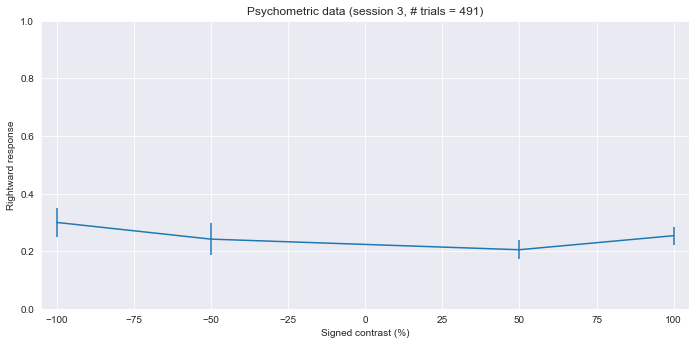

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=537266, Wed Apr  8 16:51:01 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.981317551692279e+02 1.0e+00 4.95e-01  5e-01  5e-01 0:00.0
    2     16 4.984032074633324e+02 1.3e+00 5.16e-01  5e-01  6e-01 0:00.0
    3     24 5.041585176352256e+02 1.6e+00 5.47e-01  5e-01  6e-01 0:00.0
  100    800 4.702296988798655e+02 1.2e+02 9.94e-04  2e-05  2e-03 0:00.6
  114    912 4.702296983981303e+02 3.2e+02 1.39e-04  1e-06  3e-04 0:00.7
termination on tolfun=1e-05 (Wed Apr  8 16:51:02 2020)
final/bestever f-value = 4.702297e+02 4.702297e+02
incumbent solution: [0.06266371470274809, -13.119098165487307, 8.554731774105159, 0.9524185383914734, 0.30641721115224607]
std deviation: [1.9187695562240036e-06, 0.0002653335617793004, 5.3771019360465356e-05, 2.37049228017754e-06, 1.0128118874163625e-06]

Session
4
Returned parameter vector: [  0.06266567 -13.11853676   8.55479439   0.9524159    0.30641696]
Negati

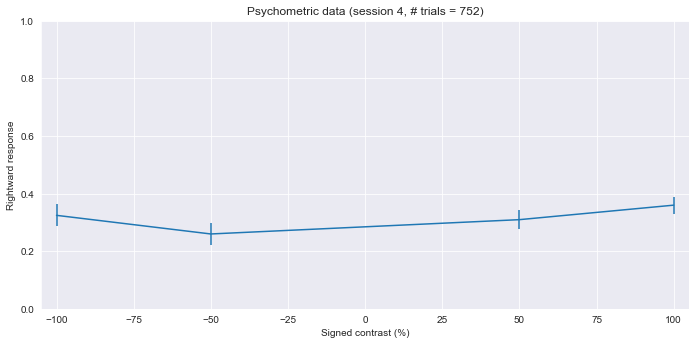

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=454530, Wed Apr  8 16:51:03 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.328881796630038e+02 1.0e+00 4.45e-01  4e-01  5e-01 0:00.0
    2     16 5.703887162370039e+02 1.2e+00 4.18e-01  4e-01  4e-01 0:00.0
    3     24 5.100387948418627e+02 1.4e+00 4.25e-01  4e-01  5e-01 0:00.0
  100    800 3.974560848755049e+02 7.3e+01 3.70e-03  7e-05  4e-03 0:00.5
  127   1016 3.974560811357003e+02 3.6e+02 3.93e-04  2e-06  5e-04 0:00.6
termination on tolfun=1e-05 (Wed Apr  8 16:51:04 2020)
final/bestever f-value = 3.974561e+02 3.974561e+02
incumbent solution: [0.08324336002934124, -10.213781019407268, 13.101087541194172, 0.9999999999854585, 0.23407916557002253]
std deviation: [3.508490351706566e-06, 0.0005142185676925541, 0.0005025588285242875, 1.0344954189603581e-05, 1.8827903094180848e-06]

Session
5
Returned parameter vector: [  0.08324336 -10.21378102  13.10108754   1.           0.23407917]
Negat

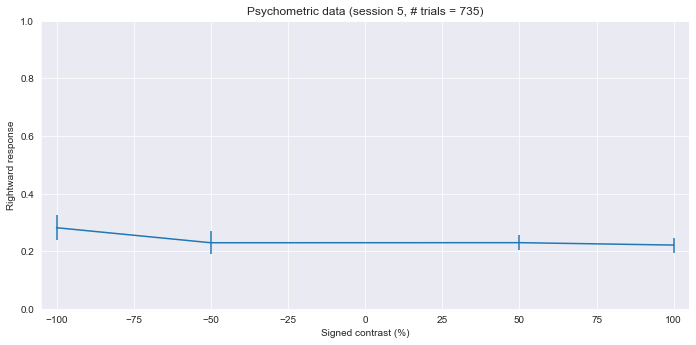

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=535476, Wed Apr  8 16:51:04 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.729143230326807e+02 1.0e+00 4.84e-01  4e-01  5e-01 0:00.0
    2     16 4.301132829142718e+02 1.3e+00 5.27e-01  5e-01  6e-01 0:00.0
    3     24 4.566332511385723e+02 1.4e+00 5.61e-01  5e-01  6e-01 0:00.0
  100    800 2.955669880946930e+02 2.5e+02 1.00e-02  2e-04  3e-02 0:00.8
NOTE (module=cma, iteration=169):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 7.1e+08 to 2.4e+03
  182   1456 2.955450719497893e+02 4.3e+01 6.89e-03  5e-06  1e-01 0:01.1
termination on tolfun=1e-05 (Wed Apr  8 16:51:06 2020)
final/bestever f-value = 2.955451e+02 2.955451e+02
incumbent solution: [0.1374563802053611, 6.744588366428372, 8.517536995449476, 0.8969194223613948, 0.03229845971959142]
std deviation: [1.587588199710093e-05, 0.10326773310597386, 0.09677875072578565, 5.632163826071428

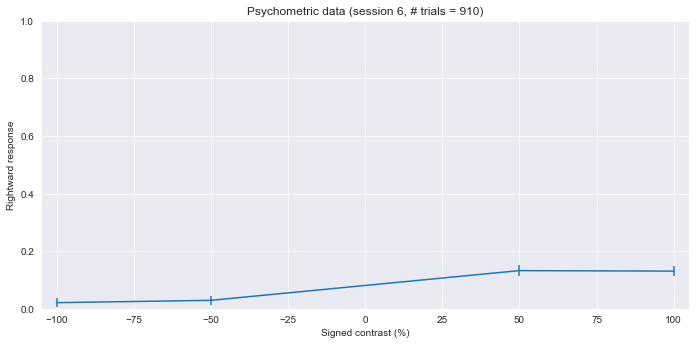

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=484659, Wed Apr  8 16:51:06 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 5.899675652342311e+02 1.0e+00 4.53e-01  4e-01  5e-01 0:00.0
    2     16 4.913085162439108e+02 1.4e+00 4.95e-01  4e-01  5e-01 0:00.0
    3     24 4.893699301049667e+02 1.5e+00 4.95e-01  5e-01  5e-01 0:00.0
  100    800 4.844482148229562e+02 2.0e+02 2.79e-01  9e-03  1e+00 0:00.5
  200   1600 4.833328520591463e+02 3.0e+03 1.55e-01  3e-04  4e-01 0:00.9
NOTE (module=cma, iteration=242):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 5.8e+08 to 2.0e+04
  250   2000 4.833326358635175e+02 1.8e+02 4.02e-02  2e-05  3e-01 0:01.0
termination on tolfun=1e-05 (Wed Apr  8 16:51:08 2020)
final/bestever f-value = 4.833326e+02 4.833326e+02
incumbent solution: [0.09447905172856284, -37.7343305555484, 15.836023436065476, 0.6744336980390064, 0.046966971584669316]
std deviation: [1.8398

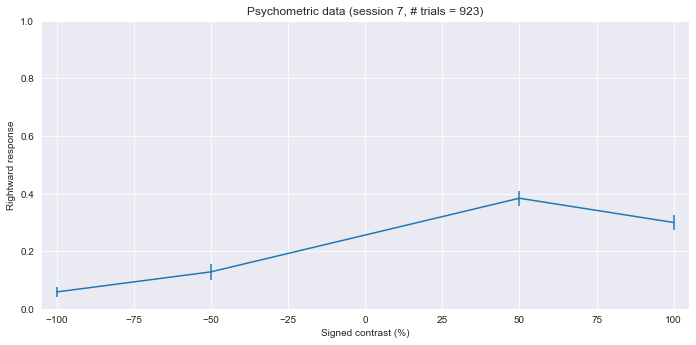

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=478321, Wed Apr  8 16:51:08 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.954008353627395e+02 1.0e+00 4.66e-01  4e-01  5e-01 0:00.0
    2     16 4.845707486460406e+02 1.3e+00 4.65e-01  4e-01  5e-01 0:00.0
    3     24 4.896314305012414e+02 1.5e+00 3.96e-01  3e-01  4e-01 0:00.0
  100    800 4.551222094323236e+02 2.1e+02 1.19e-01  4e-03  5e-01 0:00.5
  187   1496 4.550813198455124e+02 1.4e+04 9.77e-03  1e-05  9e-02 0:00.8
termination on tolfun=1e-05 (Wed Apr  8 16:51:09 2020)
final/bestever f-value = 4.550813e+02 4.550813e+02
incumbent solution: [0.06947573774987476, 9.351807745652021, 7.201550431936361, 0.558652536663977, 0.12246459519089853]
std deviation: [1.0400851807618334e-05, 0.0843716635357797, 0.09467860340636101, 1.0395721404371657e-05, 9.938894838938788e-06]

Session
8
Returned parameter vector: [0.06947574 9.35180775 7.20155043 0.55865254 0.1224646 ]
Negative log-likelihood 

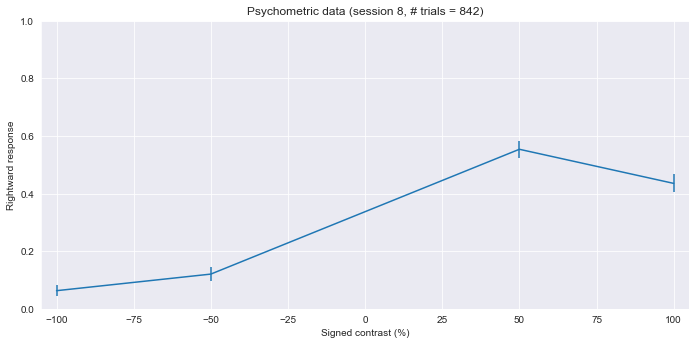

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=394269, Wed Apr  8 16:51:10 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.357473922153378e+02 1.0e+00 4.62e-01  4e-01  5e-01 0:00.0
    2     16 4.731671177979068e+02 1.3e+00 3.85e-01  3e-01  4e-01 0:00.0
    3     24 4.065068855076665e+02 1.2e+00 3.66e-01  3e-01  4e-01 0:00.0
  100    800 3.329837593283033e+02 3.1e+02 6.96e-02  9e-04  2e-01 0:00.4
  170   1360 3.329802572555178e+02 1.6e+04 9.25e-03  7e-06  7e-02 0:00.9
termination on tolfun=1e-05 (Wed Apr  8 16:51:11 2020)
final/bestever f-value = 3.329803e+02 3.329803e+02
incumbent solution: [0.051952467303635785, -11.775626701678481, 6.505003651745984, 0.5606512446051519, 2.5390206577673013e-12]
std deviation: [7.278880059009343e-06, 0.06555201725882069, 0.06891415824192346, 9.057215141906086e-06, 1.3054393737395036e-05]

Session
9
Returned parameter vector: [ 5.19524673e-02 -1.17756267e+01  6.50500365e+00  5.60651245e-01
  2.53902

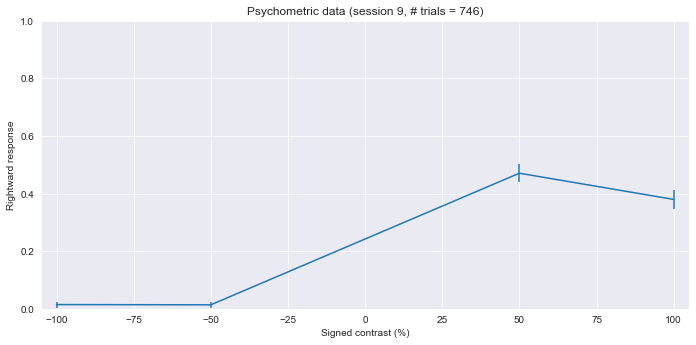

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=479829, Wed Apr  8 16:51:11 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.134746453166381e+02 1.0e+00 4.30e-01  4e-01  4e-01 0:00.0
    2     16 2.206242848759873e+02 1.3e+00 4.71e-01  4e-01  5e-01 0:00.0
    3     24 2.116832194693928e+02 1.5e+00 4.64e-01  4e-01  5e-01 0:00.0
  100    800 1.913674308698729e+02 2.3e+02 4.59e-02  1e-03  2e-01 0:00.3
NOTE (module=cma, iteration=169):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 1.8e+08 to 2.0e+02
  171   1368 1.913648453792567e+02 1.5e+01 4.00e-03  5e-06  5e-02 0:00.7
termination on tolfun=1e-05 (Wed Apr  8 16:51:12 2020)
final/bestever f-value = 1.913648e+02 1.913648e+02
incumbent solution: [0.05476412108110931, 2.33096171264169, 3.944148512581683, 0.3653809466829236, 0.8523701415904736]
std deviation: [4.6151666007083765e-06, 0.050375748114441496, 0.020685878241567243, 5.6620291815169

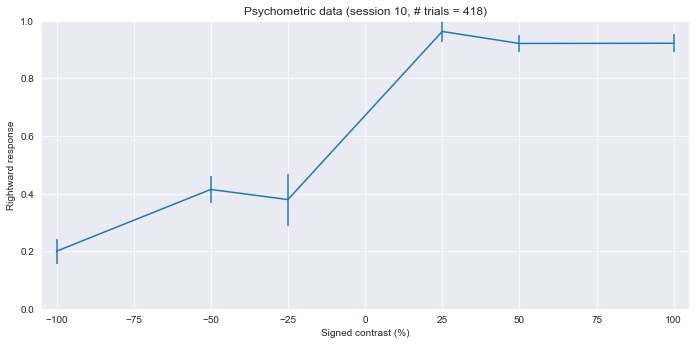

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=405407, Wed Apr  8 16:51:13 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 5.105085639077246e+02 1.0e+00 5.39e-01  5e-01  6e-01 0:00.0
    2     16 4.823955594167483e+02 1.4e+00 6.43e-01  5e-01  9e-01 0:00.0
    3     24 4.932139507945642e+02 1.9e+00 6.78e-01  5e-01  1e+00 0:00.0
  100    800 4.529727992630015e+02 2.0e+02 5.53e-02  9e-04  1e-01 0:00.4
  169   1352 4.529677687380972e+02 3.3e+02 1.26e-03  3e-06  8e-04 0:00.6
termination on tolfun=1e-05 (Wed Apr  8 16:51:14 2020)
final/bestever f-value = 4.529678e+02 4.529678e+02
incumbent solution: [0.10429667272594068, -6.319814104663932, 20.788906557649668, 0.3867536435988237, 0.16272722111409788]
std deviation: [3.3430768982638995e-06, 0.0008279728548312835, 0.0006299923312752482, 5.361528552382646e-06, 6.427153636347376e-06]

Session
11
Returned parameter vector: [ 0.10429667 -6.3198141  20.78890656  0.38675364  0.16272722]
Negative lo

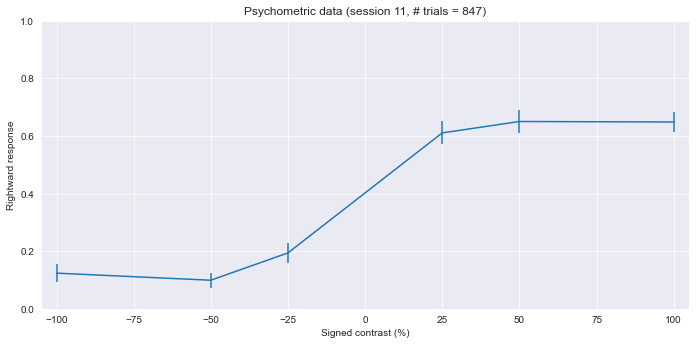

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=492382, Wed Apr  8 16:51:14 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.346081119960272e+02 1.0e+00 5.01e-01  4e-01  5e-01 0:00.0
    2     16 3.917518250123699e+02 1.3e+00 6.14e-01  5e-01  7e-01 0:00.0
    3     24 3.357723535256134e+02 1.5e+00 6.39e-01  5e-01  8e-01 0:00.0
  100    800 3.274490175175158e+02 9.9e+01 1.54e-01  4e-03  3e-01 0:00.3
  187   1496 3.267477044134883e+02 2.2e+02 1.64e-03  3e-06  6e-04 0:00.6
termination on tolfun=1e-05 (Wed Apr  8 16:51:15 2020)
final/bestever f-value = 3.267477e+02 3.267477e+02
incumbent solution: [0.10803524631555317, -9.36631885714253, 20.238472750120163, 0.16064514713106715, 0.5645567163059668]
std deviation: [3.447149732828225e-06, 0.0005696504082882685, 0.0005082377961369664, 5.24432656983615e-06, 1.3397713714785723e-05]

Session
12
Returned parameter vector: [ 0.10803525 -9.36631886 20.23847275  0.16064515  0.56455672]
Negative log-

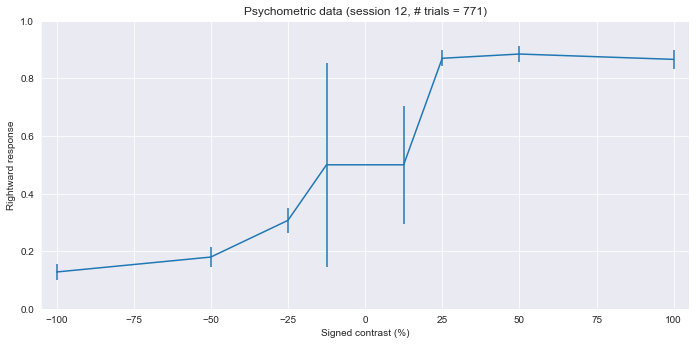

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=496298, Wed Apr  8 16:51:15 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.287929382336619e+02 1.0e+00 4.01e-01  4e-01  4e-01 0:00.0
    2     16 2.255167835388636e+02 1.2e+00 3.99e-01  3e-01  5e-01 0:00.0
    3     24 2.297233992347122e+02 1.6e+00 3.27e-01  3e-01  4e-01 0:00.0
  100    800 1.975598816102190e+02 9.4e+01 7.52e-03  1e-04  6e-03 0:00.3
  132   1056 1.975598668443481e+02 9.1e+01 3.71e-04  2e-06  1e-04 0:00.4
termination on tolfun=1e-05 (Wed Apr  8 16:51:16 2020)
final/bestever f-value = 1.975599e+02 1.975599e+02
incumbent solution: [0.03262742898974536, -4.909602917530444, 9.349016753106477, 0.053425353798281255, 0.2272971335921032]
std deviation: [2.3328234180070964e-06, 0.0001313205550525895, 0.00011470144854061104, 2.3539645509269935e-06, 1.630318159062024e-05]

Session
13
Returned parameter vector: [ 0.03262671 -4.90962303  9.34909926  0.05342426  0.22729253]
Negative 

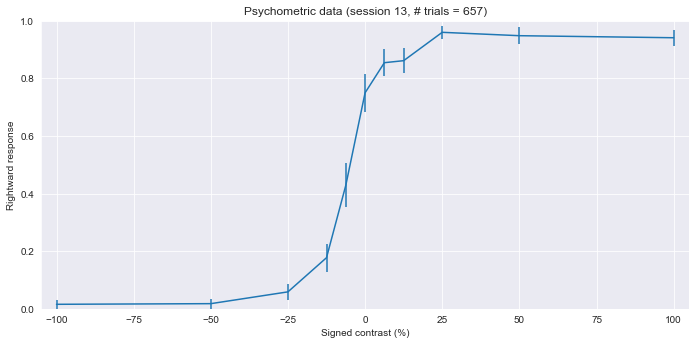

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=492185, Wed Apr  8 16:51:16 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.079524632524331e+02 1.0e+00 5.19e-01  5e-01  6e-01 0:00.0
    2     16 3.042761980792752e+02 1.4e+00 4.98e-01  4e-01  5e-01 0:00.0
    3     24 3.091680709946003e+02 1.4e+00 4.49e-01  4e-01  5e-01 0:00.0
  100    800 2.805051664661892e+02 6.7e+01 1.12e-01  2e-03  1e-01 0:00.3
  158   1264 2.804863986697497e+02 4.2e+01 7.60e-04  4e-06  2e-04 0:00.5
termination on tolfun=1e-05 (Wed Apr  8 16:51:17 2020)
final/bestever f-value = 2.804864e+02 2.804864e+02
incumbent solution: [0.15169068911395217, -2.1093827919022456, 7.181124195049213, 0.05690125955654108, 0.6223657627857747]
std deviation: [3.508752309251998e-06, 0.0001116818688497245, 0.0001540229740024551, 4.062188357662957e-06, 2.3934728897267578e-05]

Session
14
Returned parameter vector: [ 0.15168967 -2.10937486  7.18105685  0.05690272  0.62235607]
Negative lo

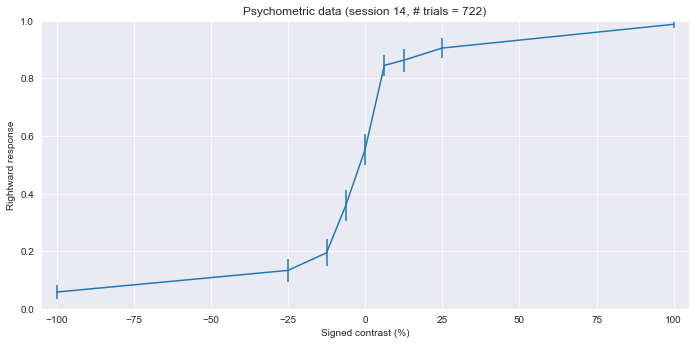

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=479096, Wed Apr  8 16:51:17 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.979326957588587e+02 1.0e+00 4.80e-01  5e-01  5e-01 0:00.0
    2     16 2.990528033418947e+02 1.3e+00 4.06e-01  4e-01  4e-01 0:00.0
    3     24 2.987704637781400e+02 1.4e+00 3.66e-01  3e-01  4e-01 0:00.0
  100    800 2.877400411540611e+02 6.9e+01 4.12e-02  9e-04  5e-02 0:00.3
  148   1184 2.877399158867336e+02 7.5e+01 2.39e-04  1e-06  6e-05 0:00.5
termination on tolfun=1e-05 (Wed Apr  8 16:51:18 2020)
final/bestever f-value = 2.877399e+02 2.877399e+02
incumbent solution: [0.18539883427700093, 2.2179893148239027, 8.740985127065736, 0.09766895525739958, 0.21909093998478546]
std deviation: [1.0459131729031717e-06, 4.646280627198294e-05, 5.846044774694965e-05, 1.3018909619644488e-06, 5.926395730994003e-06]

Session
15
Returned parameter vector: [0.18539883 2.21798931 8.74098513 0.09766896 0.21909094]
Negative log-li

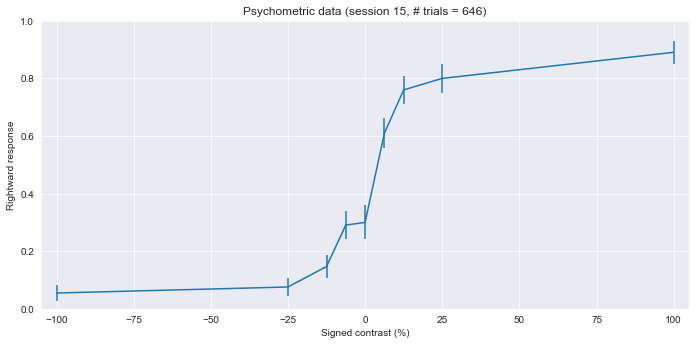

In [132]:
lb = np.array([0,-100,1,0,0])
ub = np.array([1,100,100,1,1])
bounds = [lb,ub]

plb = np.array([0.05,-25,5,0.05,0.2])
pub = np.array([0.2,25,25,0.45,0.8])
 
Rep_negLL =  []
ntrials =  []

for session_num in range(1,16): # loop over session data

    df_session = df[df['session_num'] == session_num]
    trial_mask = df['session_num'] == session_num # Indexes of trials of the chosen session
    ntrials.append(np.sum(trial_mask))

    # df_session = df[(df['session_num'] == session_num) & (df['trial_num'] > 300)]
    opt_fun = lambda theta_: -psychofun_repeatlast_loglike(theta_,df_session)

    theta0 = np.random.uniform(low=plb,high=pub)
    opts = cma.CMAOptions()
    opts.set("bounds",bounds)
    opts.set("tolfun",1e-5)
    res_repeatlast = cma.fmin(opt_fun, theta0, 0.5, opts)

    print('')
    print('Session') 
    print(session_num)
    print('Returned parameter vector: ' + str(res_repeatlast[0]))
    print('Negative log-likelihood at solution: ' + str(res_repeatlast[1]))
    
    Rep_negLL.append(res_repeatlast[1])
    
    fig = plt.figure(figsize=(9,4))
    ax = plot_psychometric_data(df_session,session_num)
    #psychofun_plot(res[0],ax)
    plt.show()

We now calculate a few model simple comparison metrics, such as AIC and BIC, for the `basic` and `repeatlast` models.

In [209]:
nparams = np.zeros(Nmodels)
results = [res,res_repeatlast] # Store all optimization output in a vector
for i in range(0,len(results)):
    nparams[i] = len(results[i][0])

nll = np.column_stack((negLL,Rep_negLL))

deltaAIC = []
deltaBIC = []

for k in range(0,15): # loop over session data
    session_num = k+1
    aic = []
    bic = []
    for i in range(0,2):
        aic.append(2*nll[k,i] + 2*nparams[i])
        #print(nparams[i])
        bic.append(2*nll[k,i] + nparams[i]*np.log(ntrials[k]))
    diff =2*nll[k,1] - 2*nll[k,0]
    print(diff)
    pen = nparams[1]*np.log(ntrials[k]) - 2*nparams[0]
    #print(diff + pen)
    
    deltaAIC.append(aic[0] - aic[1])
    deltaBIC.append(bic[0] - bic[1])
    
    
    print('Model comparison results session ' + str(session_num))
    print('The bigger, the mor efavorable for Repeat model')
    #print('delta AIC (basic - Repeated): ' + str(aic[0] - aic[1]))
    print('BIC model 1 ' + str(bic[0]))
    print('BIC model 2 ' + str(bic[1]))
    test = bic[0] - bic[1]
    
    print('AIC model 1 ' + str(aic[0]))
    print('AIC model 2 ' + str(aic[1]))
    test2 = aic[0] - aic[1]
    print('delta BIC (basic - Repeated): ' + str(test))
    print('delta AIC (basic - Repeated): ' + str(test2))
    #print('delta : ' + str(deltaAIC[k] - deltaBIC[k]))
    print('diff ' + str(test - test2))
    print('')

-1.9910255459643622
Model comparison results session 1
The bigger, the mor efavorable for Repeat model
BIC model 1 644.9570746248913
BIC model 2 649.2063249240978
AIC model 1 627.9959712442082
AIC model 2 628.0049456982439
delta BIC (basic - Repeated): -4.249250299206437
delta AIC (basic - Repeated): -0.008974454035637791
diff -4.2402758451708

-0.034079757040558434
Model comparison results session 2
The bigger, the mor efavorable for Repeat model
BIC model 1 372.91949786953023
BIC model 2 378.70550104284206
AIC model 1 357.6391661481208
AIC model 2 359.60508639108025
delta BIC (basic - Repeated): -5.786003173311826
delta AIC (basic - Repeated): -1.9659202429594416
diff -3.8200829303523847

-0.20498110290839122
Model comparison results session 3
The bigger, the mor efavorable for Repeat model
BIC model 1 570.8739612840878
BIC model 2 576.8654243089741
AIC model 1 554.0881847729098
AIC model 2 555.8832036700014
delta BIC (basic - Repeated): -5.9914630248862295
delta AIC (basic - Repeate

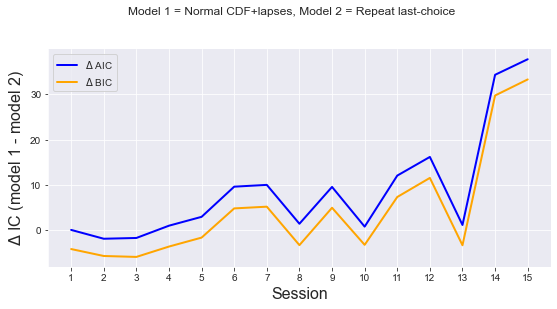

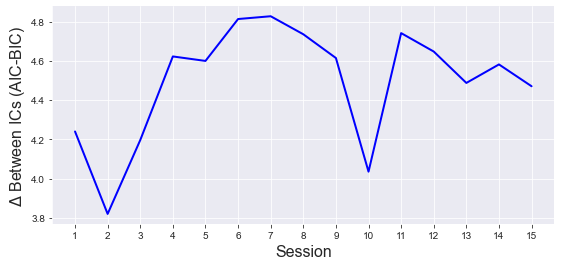

In [225]:
def plot_sess_param(X, Y1, label1, Y2=None,  label2=None, labelALL=None, caption=None):  
    sns.set_style("darkgrid")
    plt.figure(figsize=(9, 4))  
    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  
    #plt.ylim(63, 85)  
    plt.xticks(range(1, 16, 1), fontsize=10)  
    #plt.yticks(range(65, 86, 5), fontsize=14) 
    plt.xlabel("Session", fontsize=16)
    
    if caption!=None:
        plt.figtext(0.5, 1, caption, wrap=False, horizontalalignment='center', fontsize=12)
        
    if Y2==None:
        plt.ylabel(label1, fontsize=16) 
        plt.plot(sess, Y1, color="blue", lw=2)  
    else:
        plt.plot(sess, Y1, color="blue", lw=2, label=label1)  
        plt.plot(sess, Y2, color="orange", lw=2, label=label2)  
        plt.ylabel(labelALL, fontsize=16) 
        plt.legend()
    #plt.title("Theta as a function of session", fontsize=22)  
     
    #plt.savefig("XXX.png", bbox_inches="tight");  
    
plot_sess_param(session, deltaAIC, '$\Delta$ AIC',  deltaBIC, '$\Delta$ BIC', '$\Delta$ IC (model 1 - model 2)', 'Model 1 = Normal CDF+lapses, Model 2 = Repeat last-choice')
diff = np.asarray(deltaAIC) - np.asarray(deltaBIC)
plot_sess_param(session, diff, '$\Delta$ Between ICs (AIC-BIC)')


**[Advanced] Optional model:** 

We consider next a more advanced model which includes explicit time dependency (the trials are not all the same), also known as *non-stationarity*. Note that this function is not coded very efficiently and runs quite slowly due to the `for` loop - it could be improved with vectorization.

In [229]:
def psychofun_vec(theta,stim):
    """Psychometric function based on normal CDF and lapses"""
    mu = theta[:,0]          # bias
    sigma = theta[:,1]       # slope/noise
    lapse = theta[:,2]      # lapse rate
    if len(theta) == 4:    # lapse bias
        lapse_bias = theta[:,3];
    else:
        lapse_bias = np.linspace(0.5,0.5,len(theta))   # if theta has only three elements, assume symmetric lapses
    
    p_right = norm.cdf(stim,loc=mu,scale=sigma)    # Probability of responding "rightwards", without lapses
    p_right = lapse*lapse_bias + (1-lapse)*p_right # Adding lapses

    return p_right

In [231]:
def psychofun_timevarying_loglike_vec(theta,df):
    """Log-likelihood for time-varying psychometric function model"""
    s_vec = np.array(df['signed_contrast']) # Stimulus values
    r_vec = np.array(df['response_choice'])  # Responses

    Ntrials = len(s_vec)
    mu_vec = np.linspace(theta[0],theta[4],Ntrials)
    sigma_vec = np.linspace(theta[1],theta[5],Ntrials)
    lapse_vec = np.linspace(theta[2],theta[6],Ntrials)
    lapsebias_vec = np.linspace(theta[3],theta[7],Ntrials)
    ThetaVec = np.transpose(np.asarray([mu_vec,sigma_vec,lapse_vec,lapsebias_vec]))
    p_right = np.zeros(Ntrials)
    
    
    p_right = psychofun_vec(ThetaVec,s_vec)
    #print(p_right)
    # Compute summed log likelihood for all rightwards and leftwards responses
    loglike = np.sum(np.log(p_right[r_vec == 1])) + np.sum(np.log(1 - p_right[r_vec == -1]))

    return loglike



In [232]:
#theta0 = (0,20,0.1,0.5,1,20,0.1,0.5)
#ll = psychofun_timevarying_loglike_vec(theta0,df[df['session_num'] == session_num])

In [233]:
def psychofun_timevarying_loglike(theta,df):
    """Log-likelihood for time-varying psychometric function model"""
    s_vec = np.array(df['signed_contrast']) # Stimulus values
    r_vec = np.array(df['response_choice'])  # Responses

    Ntrials = len(s_vec)
    mu_vec = np.linspace(theta[0],theta[4],Ntrials)
    sigma_vec = np.linspace(theta[1],theta[5],Ntrials)
    lapse_vec = np.linspace(theta[2],theta[6],Ntrials)
    lapsebias_vec = np.linspace(theta[3],theta[7],Ntrials)

    p_right = np.zeros(Ntrials)
    
    for t in range(0,Ntrials):
        p_right[t] = psychofun([mu_vec[t],sigma_vec[t],lapse_vec[t],lapsebias_vec[t]],s_vec[t])
    #print(p_right)
    # Compute summed log likelihood for all rightwards and leftwards responses
    loglike = np.sum(np.log(p_right[r_vec == 1])) + np.sum(np.log(1 - p_right[r_vec == -1]))

    return loglike


In [ ]:
lb = np.array([-100,1,0,0,-100,1,0,0])
ub = np.array([100,100,1,1,100,100,1,1])
bounds = [lb,ub]

plb = np.array([-25,5,0.05,0.2,-25,5,0.05,0.2])
pub = np.array([25,25,0.45,0.8,25,25,0.45,0.8])

In [ ]:
#with for loops

TimeF_negLL =  []

start_time = time.time()

for session_num in range(1,16): # loop over session data

    df_session = df[df['session_num'] == session_num]

    opt_fun = lambda theta_: -psychofun_timevarying_loglike(theta_,df_session)

    theta0 = np.random.uniform(low=plb,high=pub)
    opts = cma.CMAOptions()
    opts.set("bounds",bounds)
    opts.set("tolfun",1e-5)
    res_time = cma.fmin(opt_fun, theta0, 0.5, opts)

    print('')
    print('Session') 
    print(session_num)
    print('Returned parameter vector: ' + str(res_time[0]))
    print('Negative log-likelihood at solution: ' + str(res_time[1]))
    
    TimeF_negLL.append(res_time[1])

    #fig = plt.figure(figsize=(9,4))
    #ax = plot_psychometric_data(df_session,session_num)
    #psychofun_plot(res[0],ax)
    #plt.show()
print("--- %s seconds ---" % (time.time() - start_time))


In [235]:
#vectorized

Time_negLL =  []

start_time = time.time()

for session_num in range(1,16): # loop over session data

    df_session = df[df['session_num'] == session_num]

    opt_fun = lambda theta_: -psychofun_timevarying_loglike_vec(theta_,df_session)

    theta0 = np.random.uniform(low=plb,high=pub)
    opts = cma.CMAOptions()
    opts.set("bounds",bounds)
    opts.set("tolfun",1e-5)
    res_time = cma.fmin(opt_fun, theta0, 0.5, opts)

    print('')
    print('Session') 
    print(session_num)
    print('Returned parameter vector: ' + str(res_time[0]))
    print('Negative log-likelihood at solution: ' + str(res_time[1]))
    
    Time_negLL.append(res_time[1])

    #fig = plt.figure(figsize=(9,4))
    #ax = plot_psychometric_data(df_session,session_num)
    #psychofun_plot(res[0],ax)
    #plt.show()
print("--- %s seconds ---" % (time.time() - start_time))


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=496325, Wed Apr  8 20:01:47 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 4.648878869936769e+02 1.0e+00 4.50e-01  4e-01  5e-01 0:00.0
    2     20 4.047820904038510e+02 1.1e+00 4.41e-01  4e-01  5e-01 0:00.1
    3     30 4.078323527916164e+02 1.2e+00 4.21e-01  4e-01  4e-01 0:00.1
  100   1000 3.555845057517716e+02 1.2e+02 8.37e-03  2e-04  1e-02 0:01.8
  117   1170 3.555845036761402e+02 3.0e+02 4.60e-03  4e-05  8e-03 0:02.1
termination on tolfun=1e-05 (Wed Apr  8 20:01:50 2020)
final/bestever f-value = 3.555845e+02 3.555845e+02
incumbent solution: [1.1980099229775782, 5.619329298798134, 0.9999999998581244, 0.9377936405874708, 10.381044096521885, 22.312779487485326, 0.9999999999837708, 0.597068629636387]
std deviation: [0.008385920599736554, 0.0077929311998319924, 4.11693708929329e-05, 0.0031664086476513344, 0.004771254389277412, 0.005302475792158557, 5.0415532588156856e-05, 0.00836567691

    1     10 5.332576273163447e+02 1.0e+00 4.62e-01  4e-01  5e-01 0:00.0
    2     20 5.320739411456082e+02 1.2e+00 4.41e-01  4e-01  5e-01 0:00.0
    3     30 5.316811344429474e+02 1.3e+00 4.68e-01  4e-01  6e-01 0:00.0
  100   1000 5.305197044163453e+02 6.0e+01 4.56e-01  2e-02  9e-01 0:01.2
  200   2000 4.837433648195994e+02 1.7e+03 4.74e+01  2e-01  1e+02 0:02.2
  300   3000 4.700472344160465e+02 7.8e+02 1.23e+00  2e-03  1e+00 0:03.1
  353   3530 4.700468291908512e+02 1.9e+03 2.03e-02  1e-05  2e-02 0:03.7
termination on tolfun=1e-05 (Wed Apr  8 20:02:12 2020)
final/bestever f-value = 4.700468e+02 4.700468e+02
incumbent solution: [99.99999999531414, 99.99999999625491, 0.20364568704793928, 0.03241593951959023, 47.83503229558538, 98.82470866417573, 7.939425543584421e-11, 0.2795927535080267]
std deviation: [0.0011167175054443697, 0.0013689727318168497, 1.208616642330302e-05, 0.015141743016050743, 0.001289733729682576, 0.004191026638336538, 1.16574154115458e-05, 0.011757380792154931]

Sessi

    3     30 3.619059931118339e+02 1.3e+00 3.89e-01  3e-01  4e-01 0:00.1
  100   1000 2.996918579625459e+02 5.5e+01 4.89e-01  2e-02  9e-01 0:01.2
  200   2000 2.955600044273016e+02 2.4e+02 1.78e-02  1e-04  2e-02 0:02.7
  236   2360 2.955599916282230e+02 6.0e+02 7.16e-04  2e-06  9e-04 0:03.1
termination on tolfun=1e-05 (Wed Apr  8 20:02:37 2020)
final/bestever f-value = 2.955600e+02 2.955600e+02
incumbent solution: [-1.793179081472079, 2.6594297667567957, 0.1703695465427109, 0.43001318351198226, -4.000792571522485, 16.50709921035096, 0.09019191424741227, 0.44821887590246945]
std deviation: [7.086049196240065e-05, 8.71450063559555e-05, 2.20634855602404e-06, 0.0006198209391728251, 0.00011854423229480241, 0.00015874832313838964, 2.546908038472614e-06, 0.0009458127062404736]

Session
14
Returned parameter vector: [-1.79317908  2.65942977  0.17036955  0.43001318 -4.00079257 16.50709921
  0.09019191  0.44821888]
Negative log-likelihood at solution: 295.55999162450456
(5_w,10)-aCMA-ES (mu_w=3.

In [ ]:
Nmodels = 3
nparams = np.zeros(Nmodels)
results = [res,res_repeatlast,res_time] # Store all optimization output in a vector
for i in range(0,len(results)):
    nparams[i] = len(results[i][0])

nll = np.column_stack((negLL,Rep_negLL, Time_negLL))



In [ ]:
deltaAIC_rep = []
deltaBIC_rep = []

deltaAIC_time = []
deltaBIC_time = []

#model selection
for i in range(0,15): # loop over session data
    session_num = i+1
    aic = []
    bic = []
    for j in range(0,Nmodels):
        aic.append(2*nll[i,j] + 2*nparams[j])
        #print(nparams[i])
        bic.append(2*nll[i,j] + nparams[j]*np.log(ntrials[i]))
    #diff =2*nll[k,1] - 2*nll[k,0]
    #print(diff)
    #pen = nparams[1]*np.log(ntrials[k]) - 2*nparams[0]
    #print(diff + pen)
    deltaAIC = []
    deltaBIC = []
    for k in range(1,Nmodels):
        deltaAIC.append(aic[0] - aic[k])
        deltaBIC.append(bic[0] - bic[1])
        
    deltaAIC_rep.append(deltaAIC[0])
    deltaBIC_rep.append(deltaBIC[0])
    
    deltaAIC_time.append(deltaAIC[1])
    deltaBIC_time.append(deltaBIC[1])
    
    
    print('Model comparison results session ' + str(session_num))
    print('The bigger, the more favorable for the alternative model')
    print('delta BIC (basic - Repeated) : ' + str(deltaBIC[0]))
    print('delta AIC (basic - Repeated) : ' + str(deltaAIC[0]))
    print('delta BIC (basic - Time) : ' + str(deltaBIC[1]))
    print('delta AIC (basic - Time) : ' + str(deltaAIC[1]))
    print('')


In [ ]:

plot_sess_param(session, deltaAIC_time, '$\Delta$ AIC',  deltaBIC_time, '$\Delta$ BIC', '$\Delta$ IC (model 1 - model 3)', 'Model 1 = Normal CDF+lapses, Model 3 = Time-varying')
plt.savefig(homedir+"AIC_BIC_time-varying.png")

diff = np.asarray(deltaAIC_time) - np.asarray(deltaBIC_time)
plot_sess_param(session, diff, '$\Delta$ Between ICs (AIC-BIC)')
plt.savefig(homedir+"IC_diff_time.png")